In [1]:
import pandas as pd

In [2]:
order_status = pd.read_csv("../../../downloads/olist_redefined/order_status.tsv", sep='\t').drop_duplicates()
review = pd.read_csv("../../../downloads/olist_redefined/review.tsv", sep='\t').drop_duplicates()

In [3]:
order_status['timestamp'] = pd.to_datetime(order_status['timestamp'])
review['review_creation_date'] = pd.to_datetime(review['review_creation_date'])
review['review_answer_timestamp'] = pd.to_datetime(review['review_answer_timestamp'])

In [10]:
diff_timestamp = order_status['timestamp'].diff()
diff_timestamp

0                           NaT
1               0 days 03:00:15
2               8 days 15:08:45
3               1 days 20:52:19
4               0 days 00:00:00
                  ...          
395831          5 days 03:34:48
395832          0 days 17:06:44
395833          0 days 04:07:32
395834   1 days 08:01:48.599421
395835          0 days 21:14:16
Name: timestamp, Length: 395836, dtype: timedelta64[ns]

In [12]:
diff_timestamp.describe()

count                       395835
mean     0 days 00:02:49.175195724
std      0 days 01:03:36.771236242
min                0 days 00:00:00
25%                0 days 00:00:05
50%                0 days 00:00:40
75%                0 days 00:02:00
max               17 days 09:51:14
Name: timestamp, dtype: object

In [14]:
diff_timestamp.argmax()

np.int64(5)

In [16]:
diff_timestamp.iloc[5]

Timedelta('17 days 09:51:14')

In [20]:
diff_timestamp.sort_values(ascending=False)

5        17 days 09:51:14
2         8 days 15:08:45
1256      8 days 09:40:52
1260      7 days 20:01:22
1252      6 days 06:30:12
               ...       
362492    0 days 00:00:00
362495    0 days 00:00:00
362497    0 days 00:00:00
155345    0 days 00:00:00
0                     NaT
Name: timestamp, Length: 395836, dtype: timedelta64[ns]

In [23]:
print(len(diff_timestamp[diff_timestamp.dt.days > 0]))
print(len(diff_timestamp[diff_timestamp.dt.days <= 0]))

30
395805


In [24]:
under_zero = diff_timestamp[diff_timestamp.dt.days <= 0]
under_zero.describe()

count                       395805
mean     0 days 00:02:25.607197479
std      0 days 00:14:13.482188176
min                0 days 00:00:00
25%                0 days 00:00:05
50%         0 days 00:00:39.599421
75%                0 days 00:02:00
max                0 days 23:46:29
Name: timestamp, dtype: object

In [4]:
purchase_timestamp = order_status[order_status['status'] == 'purchase']
delivered_customer_timestamp = order_status[order_status['status'] == 'delivered_customer']

In [5]:
delivered_df = pd.merge(purchase_timestamp, delivered_customer_timestamp, on='order_id', how='inner', suffixes=['_purchase', '_delivered'])
delivered_df['order_id'] = delivered_df['order_id'].astype(str)
# delivered_df.isna().value_counts()

In [6]:
delivery_lead_days = delivered_df['timestamp_delivered'] - delivered_df['timestamp_purchase']
delivery_lead_days.dt.days
# delivery_lead_days = delivery_lead_days.dt.total_seconds() / 3600 / 24

0        54
1        23
2        24
3        35
4        30
         ..
96494     1
96495     1
96496     1
96497     1
96498     1
Length: 96499, dtype: int64

In [7]:
delivery_lead_days.dt.days.describe()

count    96499.000000
mean        12.094343
std          9.551937
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
dtype: float64

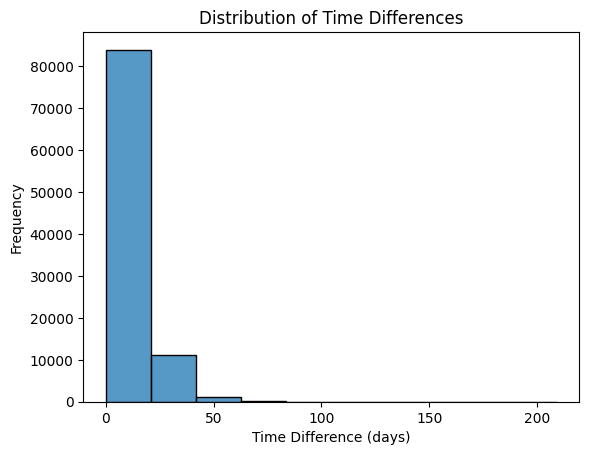

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.histplot(delivery_lead_days.dt.days, bins=10, kde=False)
plt.xlabel('Time Difference (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Time Differences')
plt.show()

## 배송 지연 시간 분포
- 75%의 데이터가 15일 이내 (Q3). 즉, 대부분 배송이 15일 안에 완료.
- 중앙값(10일)과 평균(12일)도 15일 이하로, 데이터가 이 범위에 집중됨.
- 표준편차(9.55일)를 고려해 평균 ± 2*std 로 대부분 데이터(95%) 포함 가능: `31일` 

In [9]:
delivered_review_df = delivered_df.merge(review[['order_id', 'review_creation_date', 'review_answer_timestamp']], on='order_id', how='inner')
delivered_review_df.head(2)

,order_id,status_purchase,timestamp_purchase,status_delivered,timestamp_delivered,review_creation_date,review_answer_timestamp
0,bfbd0f9bdef84302105ad712db648a6c,purchase,2016-09-15 12:16:38,delivered_customer,2016-11-09 07:47:38,2016-10-06,2016-10-07 18:32:28
1,3b697a20d9e427646d92567910af6d57,purchase,2016-10-03 09:44:50,delivered_customer,2016-10-26 14:02:13,2016-10-26,2016-10-30 21:32:15


In [10]:
review_lead_time = delivered_review_df['review_creation_date'] - delivered_review_df['timestamp_delivered']
review_lead_time.dt.days.describe()

count    96382.000000
mean        -0.541232
std          4.679442
min       -187.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        106.000000
dtype: float64

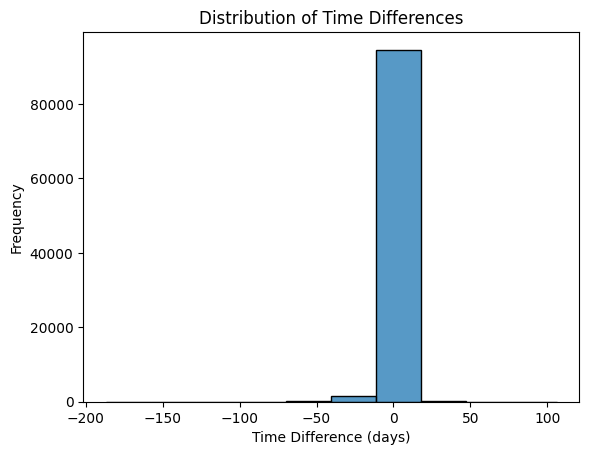

In [11]:
sns.histplot(review_lead_time.dt.days, bins=10)  # kde: 커널 밀도 추정 곡선 추가
plt.xlabel('Time Difference (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Time Differences')
plt.show()

## 리뷰의 워터마크 기간 설정
- 95%의 데이터를 포함하도록 평균 + 2*표준편차인로 설정하도록 한다: `9일`